**Inspiration:**

**Purpose: to object detection in images by using YOLOv8.**

Object detection is a computer technology related to computer vision and image processing that deals with detecting instances of semantic objects of a certain class (such as humans, buildings, or cars) in digital images and videos. When it comes to object detection, popular detection frameworks are

YOLO
SSD
Faster R-CNN

**What is YOLO exactly?**

YOLO (You Only Look Once) is a method / way to do object detection. It is the algorithm /strategy behind how the code is going to detect objects in the image.

Earlier detection frameworks, looked at different parts of the image multiple times at different scales and repurposed image classification technique to detect objects. This approach is slow and inefficient.

YOLO takes entirely different approach. It looks at the entire image only once and goes through the network once and detects objects. Hence the name. It is very fast. That’s the reason it has got so popular.

In [34]:
# 1. Install 7-Zip in the Colab environment
!apt-get install p7zip-full -y

# 2. Extract the .7z file to a folder
!7z e /content/.config/frame_9106_jpg.rf.edaac933241f83e08bf00984c0e0c85f.jpg.7z -o/content/.config -y


Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
p7zip-full is already the newest version (16.02+dfsg-8).
0 upgraded, 0 newly installed, 0 to remove and 35 not upgraded.

7-Zip [64] 16.02 : Copyright (c) 1999-2016 Igor Pavlov : 2016-05-21
p7zip Version 16.02 (locale=en_US.UTF-8,Utf16=on,HugeFiles=on,64 bits,2 CPUs Intel(R) Xeon(R) CPU @ 2.00GHz (50653),ASM,AES-NI)

Scanning the drive for archives:
  0M Scan /content/.config/                           1 file, 27908 bytes (28 KiB)

Extracting archive: /content/.config/frame_9106_jpg.rf.edaac933241f83e08bf00984c0e0c85f.jpg.7z
--
Path = /content/.config/frame_9106_jpg.rf.edaac933241f83e08bf00984c0e0c85f.jpg.7z
Type = 7z
Physical Size = 27908
Headers Size = 218
Method = LZMA2:15
Solid = -
Blocks = 1

  0%    Everything is Ok

Size:       28456
Compressed: 27908


In [35]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


**Import Libraries**

In [36]:
import numpy as np
import pandas as pd
import cv2

from sklearn.utils import shuffle
from matplotlib.patches import Rectangle
import matplotlib.pyplot as plt

import warnings

warnings.simplefilter('ignore')

**Loading the Data**


In [37]:
from google.colab import files
uploaded = files.upload()

Saving Vehicles_Detection.v8i.yolov8.zip to Vehicles_Detection.v8i.yolov8.zip


In [38]:
import zipfile
import os

zip_path = "/content/Vehicles_Detection.v8i.yolov8.zip"
extract_path = "/content/Vehicles_Detection"

# Extract ZIP
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)




In [39]:
import os

train_path = "/content/Vehicles_Detection/Vehicles_Detection.v8i.yolov8/train"
valid_path = "/content/Vehicles_Detection/Vehicles_Detection.v8i.yolov8/valid"

print("Train contents:", os.listdir(train_path))
print("Valid contents:", os.listdir(valid_path))


Train contents: ['images', 'labels']
Valid contents: ['images', 'labels']


In [40]:
os.listdir(f"{train_path}/labels")[:3]  # should show .txt files


['frame_4031_jpg.rf.906ca8fac08d4f5b334e15abb7528997.txt',
 'frame_8649_jpg.rf.2fe2a3f11a3c56eeeaa2f46ec2e5e65c.txt',
 'frame_1037_jpg.rf.47a32f199219623c5a3aa624b2f57931.txt']

# **Classes**

In [41]:
with open("/content/Vehicles_Detection/Vehicles_Detection.v8i.yolov8/data.yaml") as f:
    print(f.read())


train: ../train/images
val: ../valid/images
test: ../test/images

nc: 5
names: ['Bus', 'Car', 'Motorcycle', 'Pickup', 'Truck']

roboflow:
  workspace: hana-v8gbl
  project: vehicles_detection-gvrhr
  version: 8
  license: Private
  url: https://app.roboflow.com/hana-v8gbl/vehicles_detection-gvrhr/8


**Visualizing some images**

In [42]:
# Path to training images and labels
train_images_path = "/content/Vehicles_Detection/Vehicles_Detection.v8i.yolov8/train/images"
train_labels_path = "/content/Vehicles_Detection/Vehicles_Detection.v8i.yolov8/train/labels"

# List all image files in the training set
image_files = [f for f in os.listdir(train_images_path) if f.endswith(('.jpg', '.jpeg', '.png'))]


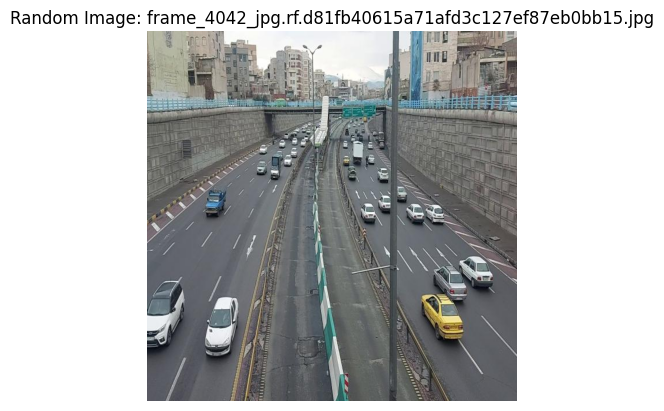

In [43]:
import os
import random
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Define the path to training images
train_images_path = "/content/Vehicles_Detection/Vehicles_Detection.v8i.yolov8/train/images"

# Get list of image files
image_files = [f for f in os.listdir(train_images_path) if f.lower().endswith(('.jpg', '.jpeg', '.png'))]

# Choose a random image
img_file = random.choice(image_files)

# Full path to the selected image
img_path = os.path.join(train_images_path, img_file)

# Display the image
img = mpimg.imread(img_path)
plt.imshow(img)
plt.title(f"Random Image: {img_file}")
plt.axis('off')
plt.show()



In [44]:
# Load the corresponding label file (.txt) for the chosen image
label_file = img_file.replace('.jpg', '.txt').replace('.jpeg', '.txt').replace('.png', '.txt')
label_path = os.path.join(train_labels_path, label_file)

# Check if the label file exists
if os.path.exists(label_path):
    with open(label_path, 'r') as f:
        lines = f.readlines()
else:
    print(f"No label file found for {img_file}")


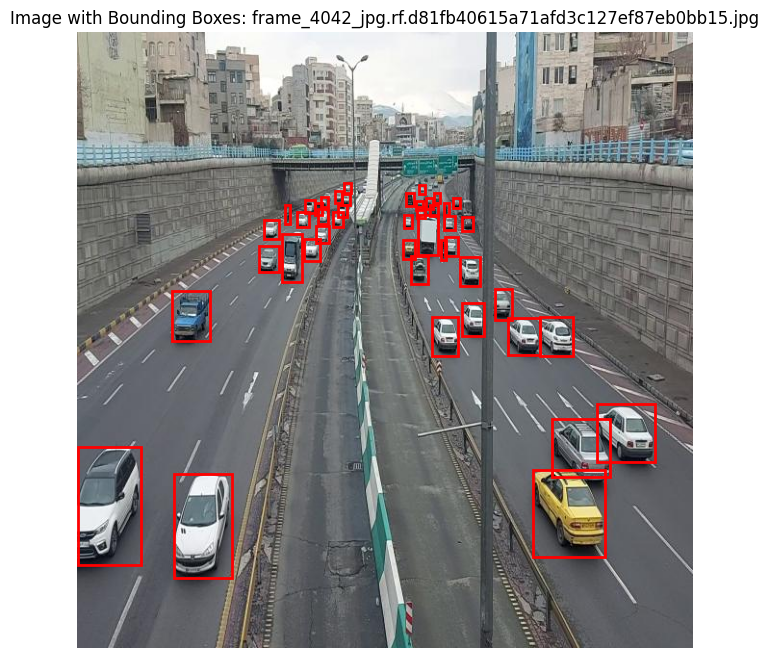

In [45]:
if os.path.exists(label_path):
    # Set up the plot for overlaying bounding boxes
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.imshow(img)

    # Loop through each bounding box and draw it on the image
    for line in lines:
        # Each line contains: <class_id> <x_center> <y_center> <width> <height> (normalized)
        class_id, x_center, y_center, width, height = map(float, line.strip().split())

        # Convert normalized values to pixel values
        img_width, img_height = img.shape[1], img.shape[0]
        x_center *= img_width
        y_center *= img_height
        width *= img_width
        height *= img_height

        # Calculate the bounding box coordinates
        x1 = x_center - width / 2
        y1 = y_center - height / 2
        x2 = x_center + width / 2
        y2 = y_center + height / 2

        # Draw the bounding box
        ax.add_patch(plt.Rectangle((x1, y1), width, height, linewidth=2, edgecolor='r', facecolor='none'))

    plt.axis('off')
    plt.title(f"Image with Bounding Boxes: {img_file}")
    plt.show()


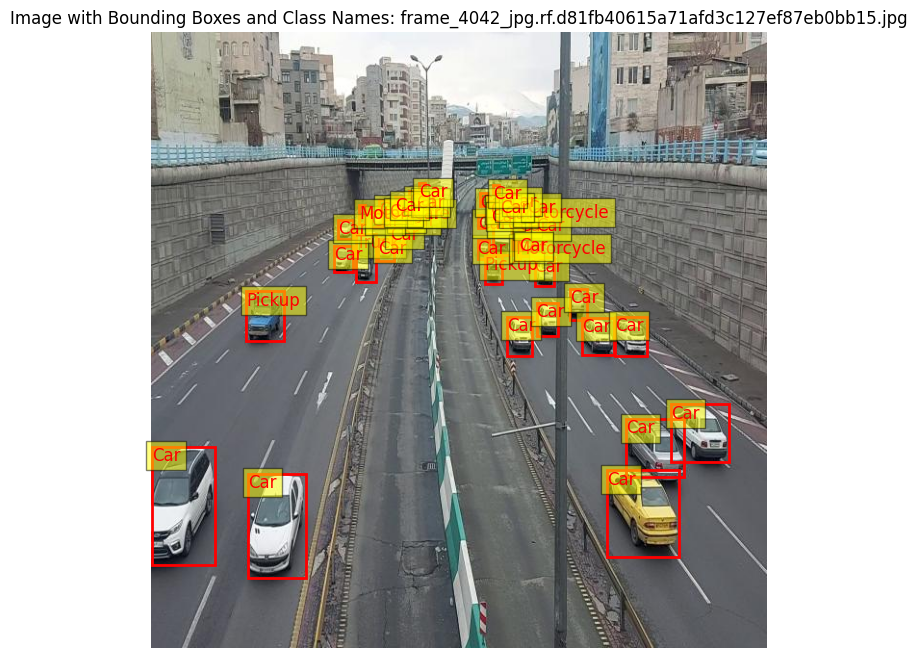

In [46]:
# Define class names as per your 'data.yaml' file
class_names = ['Bus', 'Car', 'Motorcycle', 'Pickup', 'Truck']

if os.path.exists(label_path):
    # Set up the plot for overlaying bounding boxes
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.imshow(img)

    # Loop through each bounding box and draw it on the image
    for line in lines:
        # Each line contains: <class_id> <x_center> <y_center> <width> <height> (normalized)
        class_id, x_center, y_center, width, height = map(float, line.strip().split())

        # Convert normalized values to pixel values
        img_width, img_height = img.shape[1], img.shape[0]
        x_center *= img_width
        y_center *= img_height
        width *= img_width
        height *= img_height

        # Calculate the bounding box coordinates
        x1 = x_center - width / 2
        y1 = y_center - height / 2
        x2 = x_center + width / 2
        y2 = y_center + height / 2

        # Draw the bounding box
        ax.add_patch(plt.Rectangle((x1, y1), width, height, linewidth=2, edgecolor='r', facecolor='none'))

        # Add the class name as text on the image
        class_name = class_names[int(class_id)]  # Fetch class name from class_id
        ax.text(x1, y1, class_name, color='red', fontsize=12, verticalalignment='top', horizontalalignment='left',
                bbox=dict(facecolor='yellow', alpha=0.5))

    plt.axis('off')
    plt.title(f"Image with Bounding Boxes and Class Names: {img_file}")
    plt.show()


**Importing the Pretrained Model model**

In [47]:
!pip install ultralytics


In [48]:
from ultralytics import YOLO
import PIL
from PIL import Image
from IPython.display import display
import os
import pathlib

In [49]:
model = YOLO("yolov8m.pt")

**Analyzing YOLOv8 Detection Results: Object Classes, Coordinates, and Confidence Scores**

In [50]:
import os

base_path = "/content"
for root, dirs, files in os.walk(base_path):
    if 'frame' in str(files):  # We check for image-like names
        print(f"📁 {root}")
        for file in files:
            print(f"   - {file}")


📁 /content/.config
   - default_configs.db
   - config_sentinel
   - active_config
   - .last_opt_in_prompt.yaml
   - .last_update_check.json
   - .last_survey_prompt.yaml
   - hidden_gcloud_config_universe_descriptor_data_cache_configs.db
   - gce
   - frame_9106_jpg.rf.edaac933241f83e08bf00984c0e0c85f.jpg.7z
   - frame_9106_jpg.rf.edaac933241f83e08bf00984c0e0c85f.jpg
📁 /content/Vehicles_Detection/Vehicles_Detection.v8i.yolov8/test/images
   - frame_6406_jpg.rf.ff63b851413c468025e0f9f2dad80fd0.jpg
   - frame_1806_jpg.rf.4583992e61114207bd9379b7e0652549.jpg
   - frame_1018_jpg.rf.185b0b25bb53e1d0eb860dda162bb2ae.jpg
   - frame_9486_jpg.rf.2280c498ddc7234aff225ca73be23450.jpg
   - frame_1004_jpg.rf.a6f441255e54620ea11fb3cf34fc0a97.jpg
   - frame_7929_jpg.rf.02b89050254d7e4c8c8995125a555cfe.jpg
   - frame_0990_jpg.rf.a3223422e734a57442ee34a58d24d4b4.jpg
   - frame_4363_jpg.rf.1b2237d870de9cc7618a46bf229d23ed.jpg
   - frame_9055_jpg.rf.067db6b83a7de9859840f6ca2484d373.jpg
   - frame_3837_

In [51]:
import os

# List all files in the folder
extracted_files = os.listdir('/content/.config')
print("Extracted files:", extracted_files)


Extracted files: ['default_configs.db', 'config_sentinel', 'active_config', '.last_opt_in_prompt.yaml', 'configurations', 'logs', '.last_update_check.json', '.last_survey_prompt.yaml', 'hidden_gcloud_config_universe_descriptor_data_cache_configs.db', 'gce', 'frame_9106_jpg.rf.edaac933241f83e08bf00984c0e0c85f.jpg.7z', 'frame_9106_jpg.rf.edaac933241f83e08bf00984c0e0c85f.jpg']



image 1/1 /content/.config/frame_9106_jpg.rf.edaac933241f83e08bf00984c0e0c85f.jpg: 640x640 2 cars, 2 trucks, 37.3ms
Speed: 2.8ms preprocess, 37.3ms inference, 2.7ms postprocess per image at shape (1, 3, 640, 640)


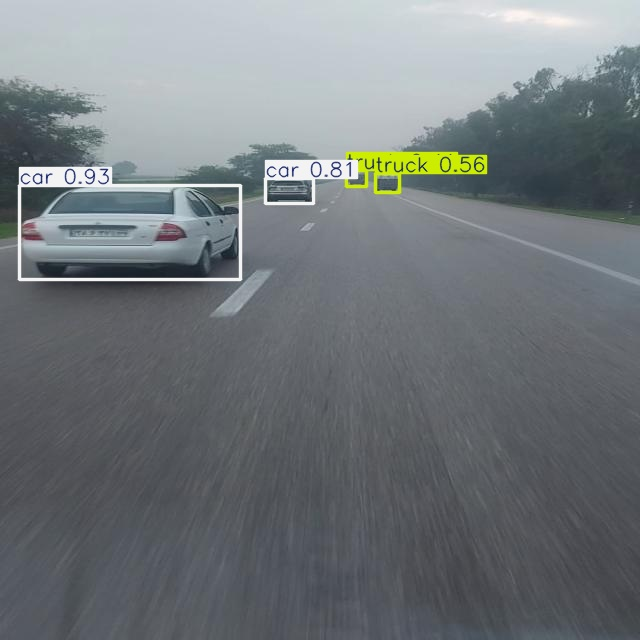

In [52]:
from ultralytics import YOLO
from IPython.display import Image, display

# Load your trained or pre-trained YOLOv8 model
model = YOLO('/content/yolov8m.pt')  # or your own model path

# Define the path to the extracted image
image_path = '/content/.config/frame_9106_jpg.rf.edaac933241f83e08bf00984c0e0c85f.jpg'

# Run prediction
results = model.predict(source=image_path, conf=0.3)

# Display the result image (YOLOv8 saves it automatically)
results[0].save(filename="/content/detected.jpg")
display(Image(filename="/content/detected.jpg"))



image 1/1 /content/.config/frame_9106_jpg.rf.edaac933241f83e08bf00984c0e0c85f.jpg: 640x640 2 cars, 2 trucks, 37.3ms
Speed: 1.9ms preprocess, 37.3ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)


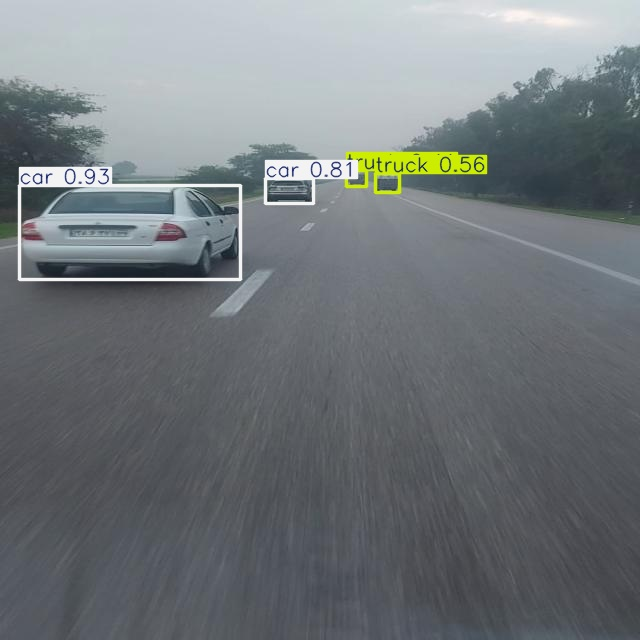

Object type: car
Coordinates: [20, 185, 240, 279]
Probability: 0.93
---
Object type: car
Coordinates: [266, 178, 313, 204]
Probability: 0.81
---
Object type: truck
Coordinates: [375, 173, 399, 192]
Probability: 0.56
---
Object type: truck
Coordinates: [347, 171, 367, 186]
Probability: 0.41
---


In [53]:
from ultralytics import YOLO
from IPython.display import Image, display

# Load a YOLOv8 model (pretrained or your custom one)
model = YOLO('/content/yolov8m.pt')  # Use your own model if available

# Set the image path
image_path = '/content/.config/frame_9106_jpg.rf.edaac933241f83e08bf00984c0e0c85f.jpg'

# Run prediction
results = model.predict(source=image_path, conf=0.3)

# Save and display the detected image
results[0].save(filename='/content/detected.jpg')
display(Image('/content/detected.jpg'))

# Access the model's class names directly
class_names = model.names

# Iterate over each detected object in the results
for box in results[0].boxes:
    # Get the class name (car, motorcycle, etc.)
    class_id = class_names[box.cls[0].item()]  # Get the class label using the class ID

    # Get the coordinates of the bounding box
    cords = box.xyxy[0].tolist()  # Format: [x1, y1, x2, y2]
    cords = [round(x) for x in cords]  # Round the coordinates to make them integers

    # Get the confidence score
    conf = round(box.conf[0].item(), 2)  # Round the confidence score to 2 decimal places

    # Print the results
    print("Object type:", class_id)
    print("Coordinates:", cords)
    print("Probability:", conf)
    print("---")


**MODEL BUILDING**

 **Configure Training**

In [5]:
!ls /content/


sample_data


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
!ls /content/sample_data/


 anscombe.json		        mnist_train_small.csv
 california_housing_test.csv    README.md
 california_housing_train.csv  'Vehicles_Detection.v8i.yolov8 (3).zip'
 mnist_test.csv


In [5]:
!unzip "/content/sample_data/Vehicles_Detection.v8i.yolov8 (3).zip" -d /content/your_dataset


Archive:  /content/sample_data/Vehicles_Detection.v8i.yolov8 (3).zip
   creating: /content/your_dataset/Vehicles_Detection.v8i.yolov8/
  inflating: /content/your_dataset/Vehicles_Detection.v8i.yolov8/data.yaml  
   creating: /content/your_dataset/Vehicles_Detection.v8i.yolov8/test/
   creating: /content/your_dataset/Vehicles_Detection.v8i.yolov8/test/images/
  inflating: /content/your_dataset/Vehicles_Detection.v8i.yolov8/test/images/frame_0990_jpg.rf.a3223422e734a57442ee34a58d24d4b4.jpg  
  inflating: /content/your_dataset/Vehicles_Detection.v8i.yolov8/test/images/frame_1004_jpg.rf.a6f441255e54620ea11fb3cf34fc0a97.jpg  
  inflating: /content/your_dataset/Vehicles_Detection.v8i.yolov8/test/images/frame_1018_jpg.rf.185b0b25bb53e1d0eb860dda162bb2ae.jpg  
  inflating: /content/your_dataset/Vehicles_Detection.v8i.yolov8/test/images/frame_1806_jpg.rf.4583992e61114207bd9379b7e0652549.jpg  
  inflating: /content/your_dataset/Vehicles_Detection.v8i.yolov8/test/images/frame_3837_jpg.rf.7cdff66e

In [8]:
yaml_content = """
train: /content/your_dataset/images/train
val: /content/your_dataset/images/val
test: /content/your_dataset/images/test

nc: 5
names: ['class_0', 'class_1', 'class_2', 'class_3', 'class_4']
"""

with open('dataset.yaml', 'w') as f:
    f.write(yaml_content)

In [10]:
!pip install ultralytics



   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 19.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 1.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 14.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 22.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 28.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 858.1 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 6.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 82.4 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling

In [20]:
!unzip "Vehicles_Detection.v8i.yolov8 (3).zip" -d /content/dataset

unzip:  cannot find or open Vehicles_Detection.v8i.yolov8 (3).zip, Vehicles_Detection.v8i.yolov8 (3).zip.zip or Vehicles_Detection.v8i.yolov8 (3).zip.ZIP.


In [21]:
!ls /content/your_dataset/Vehicles_Detection.v8i.yolov8

data.yaml  test  train	valid


In [22]:
%%writefile dataset.yaml
path: /content/your_dataset/Vehicles_Detection.v8i.yolov8
train: train/images
val: valid/images
test: test/images

# Update these with your actual class information
nc: 5  # Number of classes
names: ['class_0', 'class_1', 'class_2', 'class_3', 'class_4']  # Class names

Overwriting dataset.yaml


In [23]:
# Check training images exist
!ls /content/your_dataset/Vehicles_Detection.v8i.yolov8/train/images | head -5

# Check validation images exist
!ls /content/your_dataset/Vehicles_Detection.v8i.yolov8/valid/images | head -5

frame_0002_jpg.rf.a929cd43bfa0953ace4ea9ea00fa9ba7.jpg
frame_0087_jpg.rf.6911e25ecb00139750616b606571e714.jpg
frame_0182_jpg.rf.24ccc1dc2e78b06ec38094471560e981.jpg
frame_0435_jpg.rf.b64a627a937f4b21417074ddc983c184.jpg
frame_0654_jpg.rf.a078b9fb055bd8aabc4ea0269670ec31.jpg
frame_0143_jpg.rf.f11c115e321f53745290e2b2dfcad380.jpg
frame_0911_jpg.rf.f800706c68aaa14bb6a69146facf7e48.jpg
frame_1002_jpg.rf.2b25d8377146e3cf66aea4b2f3836d2d.jpg
frame_1007_jpg.rf.0cbfce7666ca0c0b40922863f0b9484c.jpg
frame_1010_jpg.rf.130eb218ff310e902d6f889e3fc756ee.jpg


**Run Training**

In [24]:
from ultralytics import YOLO
import torch

# 1. Verify dataset structure
print("Verifying training images...")
!ls -lh "/content/your_dataset/Vehicles_Detection.v8i.yolov8/train/images" | head -5
print("\nVerifying validation images...")
!ls -lh "/content/your_dataset/Vehicles_Detection.v8i.yolov8/valid/images" | head -5

# 2. Load model (this will automatically download yolov8n.pt if not present)
model = YOLO("yolov8n.pt")  # You can also use "yolov8s.pt", "yolov8m.pt" etc.

# 3. Start training
results = model.train(
    data="dataset.yaml",
    epochs=30,
    batch=16,  # Reduce to 8 if you get CUDA out of memory errors
    imgsz=640,
    patience=10,  # Stop training if no improvement for 10 epochs
    device='cuda' if torch.cuda.is_available() else 'cpu',
    workers=8,
    optimizer='auto',
    lr0=0.01,  # Initial learning rate
    lrf=0.01,  # Final learning rate
    momentum=0.937,
    weight_decay=0.0005,
    warmup_epochs=3.0,
    warmup_momentum=0.8,
    warmup_bias_lr=0.1,
    box=7.5,  # box loss gain
    cls=0.5,  # cls loss gain
    dfl=1.5,  # dfl loss gain
    close_mosaic=10,  # Disable mosaic augmentation last 10 epochs
)

Verifying training images...
total 6.6M
-rw-rw-rw- 1 root root 82K Jul 27 02:28 frame_0002_jpg.rf.a929cd43bfa0953ace4ea9ea00fa9ba7.jpg
-rw-rw-rw- 1 root root 32K Jul 27 02:28 frame_0087_jpg.rf.6911e25ecb00139750616b606571e714.jpg
-rw-rw-rw- 1 root root 33K Jul 27 02:28 frame_0182_jpg.rf.24ccc1dc2e78b06ec38094471560e981.jpg
-rw-rw-rw- 1 root root 80K Jul 27 02:28 frame_0435_jpg.rf.b64a627a937f4b21417074ddc983c184.jpg

Verifying validation images...
total 1.9M
-rw-rw-rw- 1 root root 34K Jul 27 02:28 frame_0143_jpg.rf.f11c115e321f53745290e2b2dfcad380.jpg
-rw-rw-rw- 1 root root 80K Jul 27 02:28 frame_0911_jpg.rf.f800706c68aaa14bb6a69146facf7e48.jpg
-rw-rw-rw- 1 root root 79K Jul 27 02:28 frame_1002_jpg.rf.2b25d8377146e3cf66aea4b2f3836d2d.jpg
-rw-rw-rw- 1 root root 78K Jul 27 02:28 frame_1007_jpg.rf.0cbfce7666ca0c0b40922863f0b9484c.jpg
Ultralytics 8.3.170 🚀 Python-3.11.13 torch-2.6.0+cu124 CPU (Intel Xeon 2.20GHz)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=ran

100%|██████████| 755k/755k [00:00<00:00, 15.2MB/s]

Overriding model.yaml nc=80 with nc=5

                   from  n    params  module                                       arguments                     
  0                  -1  1       464  ultralytics.nn.modules.conv.Conv             [3, 16, 3, 2]                 
  1                  -1  1      4672  ultralytics.nn.modules.conv.Conv             [16, 32, 3, 2]                
  2                  -1  1      7360  ultralytics.nn.modules.block.C2f             [32, 32, 1, True]             
  3                  -1  1     18560  ultralytics.nn.modules.conv.Conv             [32, 64, 3, 2]                
  4                  -1  2     49664  ultralytics.nn.modules.block.C2f             [64, 64, 2, True]             
  5                  -1  1     73984  ultralytics.nn.modules.conv.Conv             [64, 128, 3, 2]               
  6                  -1  2    197632  ultralytics.nn.modules.block.C2f             [128, 128, 2, True]           
  7                  -1  1    295424  ultralytics

 21                  -1  1    493056  ultralytics.nn.modules.block.C2f             [384, 256, 1]                 
 22        [15, 18, 21]  1    752287  ultralytics.nn.modules.head.Detect           [5, [64, 128, 256]]           
Model summary: 129 layers, 3,011,823 parameters, 3,011,807 gradients, 8.2 GFLOPs

Transferred 319/355 items from pretrained weights
Freezing layer 'model.22.dfl.conv.weight'
train: Fast image access ✅ (ping: 0.0±0.0 ms, read: 18.3±8.6 MB/s, size: 47.7 KB)


train: Scanning /content/your_dataset/Vehicles_Detection.v8i.yolov8/train/labels... 102 images, 1 backgrounds, 0 corrupt: 100%|██████████| 102/102 [00:00<00:00, 305.99it/s]

train: New cache created: /content/your_dataset/Vehicles_Detection.v8i.yolov8/train/labels.cache


albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 77.2±74.0 MB/s, size: 56.1 KB)


val: Scanning /content/your_dataset/Vehicles_Detection.v8i.yolov8/valid/labels... 28 images, 0 backgrounds, 0 corrupt: 100%|██████████| 28/28 [00:00<00:00, 396.82it/s]

val: New cache created: /content/your_dataset/Vehicles_Detection.v8i.yolov8/valid/labels.cache


Plotting labels to runs/detect/train6/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.001111, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 0 dataloader workers
Logging results to runs/detect/train6
Starting training for 30 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/30         0G      1.347      4.143      1.044        138        640: 100%|██████████| 7/7 [01:51<00:00, 15.94s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:09<00:00,  9.68s/it]

                   all         28        563     0.0142      0.206     0.0826     0.0609



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/30         0G      1.342      3.376     0.9679         95        640: 100%|██████████| 7/7 [01:39<00:00, 14.14s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:09<00:00,  9.76s/it]

                   all         28        563     0.0173      0.296     0.0568     0.0256



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/30         0G      1.387      2.045     0.9492         99        640: 100%|██████████| 7/7 [01:35<00:00, 13.59s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:12<00:00, 12.99s/it]

                   all         28        563     0.0373      0.375      0.119     0.0739



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/30         0G      1.334      1.703     0.9257        219        640: 100%|██████████| 7/7 [01:45<00:00, 15.09s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:10<00:00, 10.13s/it]

                   all         28        563      0.048      0.387      0.151     0.0921



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/30         0G      1.355      1.588     0.9494        111        640: 100%|██████████| 7/7 [01:36<00:00, 13.75s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:08<00:00,  8.49s/it]

                   all         28        563      0.042      0.461      0.201      0.126



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/30         0G      1.302      1.437     0.9295        216        640: 100%|██████████| 7/7 [01:29<00:00, 12.75s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:08<00:00,  8.88s/it]

                   all         28        563     0.0438      0.517      0.237      0.146



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/30         0G      1.245      1.385     0.9383        263        640: 100%|██████████| 7/7 [01:37<00:00, 13.98s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:09<00:00,  9.59s/it]

                   all         28        563     0.0422      0.464      0.266      0.169



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/30         0G      1.231      1.312     0.9245        176        640: 100%|██████████| 7/7 [01:33<00:00, 13.32s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:08<00:00,  8.94s/it]

                   all         28        563      0.566       0.19      0.291       0.18



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/30         0G      1.217      1.228     0.9111        199        640: 100%|██████████| 7/7 [01:28<00:00, 12.70s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:09<00:00,  9.47s/it]

                   all         28        563      0.894     0.0596      0.276      0.174



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/30         0G      1.188      1.253     0.9258        151        640: 100%|██████████| 7/7 [01:31<00:00, 13.14s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:09<00:00,  9.70s/it]

                   all         28        563        0.8     0.0676      0.313      0.192



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/30         0G      1.214       1.23     0.9257        170        640: 100%|██████████| 7/7 [01:28<00:00, 12.57s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:09<00:00,  9.69s/it]

                   all         28        563      0.674      0.185      0.383      0.242



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/30         0G      1.208      1.167     0.9166        131        640: 100%|██████████| 7/7 [01:28<00:00, 12.58s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:09<00:00,  9.82s/it]

                   all         28        563      0.781      0.258      0.416      0.245



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/30         0G      1.131      1.102     0.9032        135        640: 100%|██████████| 7/7 [01:33<00:00, 13.30s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:08<00:00,  8.79s/it]

                   all         28        563      0.736      0.243      0.418      0.251



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/30         0G       1.14       1.09     0.9202        127        640: 100%|██████████| 7/7 [01:29<00:00, 12.78s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:08<00:00,  8.65s/it]

                   all         28        563      0.673      0.281      0.459      0.295



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/30         0G      1.162      1.147      0.906        220        640: 100%|██████████| 7/7 [01:29<00:00, 12.81s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:08<00:00,  8.66s/it]

                   all         28        563      0.609      0.383       0.49      0.319



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/30         0G      1.169      1.106     0.9146        205        640: 100%|██████████| 7/7 [01:34<00:00, 13.47s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:08<00:00,  8.74s/it]

                   all         28        563      0.608      0.409      0.492       0.31



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/30         0G      1.117      1.046     0.9035        151        640: 100%|██████████| 7/7 [01:28<00:00, 12.67s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:09<00:00,  9.12s/it]

                   all         28        563      0.631      0.455      0.502       0.31



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/30         0G      1.107      1.052      0.904        187        640: 100%|██████████| 7/7 [01:30<00:00, 12.90s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:10<00:00, 10.12s/it]

                   all         28        563      0.618      0.451      0.504      0.307



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/30         0G      1.114      1.056     0.9064        158        640: 100%|██████████| 7/7 [01:31<00:00, 13.02s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:09<00:00,  9.99s/it]

                   all         28        563      0.606      0.463      0.509      0.313



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/30         0G      1.111      1.017      0.901        227        640: 100%|██████████| 7/7 [01:33<00:00, 13.37s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:08<00:00,  8.86s/it]

                   all         28        563      0.568      0.476      0.502      0.314


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/30         0G      1.085     0.9972     0.9043         83        640: 100%|██████████| 7/7 [01:25<00:00, 12.24s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:09<00:00,  9.95s/it]

                   all         28        563      0.539      0.461      0.522       0.33



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/30         0G      1.076      1.004     0.9024         81        640: 100%|██████████| 7/7 [01:25<00:00, 12.28s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:10<00:00, 10.03s/it]

                   all         28        563      0.676      0.443      0.514      0.334



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/30         0G       1.08     0.9916     0.8974        147        640: 100%|██████████| 7/7 [01:26<00:00, 12.33s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:09<00:00,  9.96s/it]

                   all         28        563       0.65      0.475      0.532      0.349



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/30         0G       1.06     0.9486     0.8884         81        640: 100%|██████████| 7/7 [01:26<00:00, 12.35s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:09<00:00,  9.99s/it]

                   all         28        563      0.585      0.479      0.544      0.362



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/30         0G      1.052     0.9512     0.8917         96        640: 100%|██████████| 7/7 [01:25<00:00, 12.25s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:10<00:00, 10.05s/it]

                   all         28        563      0.579      0.493      0.541      0.364



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/30         0G      1.055      1.001     0.8786         56        640: 100%|██████████| 7/7 [01:26<00:00, 12.41s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:10<00:00, 10.18s/it]

                   all         28        563      0.622      0.461       0.53      0.356



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/30         0G      1.035     0.9328     0.8838        169        640: 100%|██████████| 7/7 [01:26<00:00, 12.41s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:10<00:00, 10.42s/it]

                   all         28        563      0.582      0.482      0.539      0.373



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/30         0G      1.031     0.9217     0.8796        164        640: 100%|██████████| 7/7 [01:29<00:00, 12.75s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:10<00:00, 10.09s/it]

                   all         28        563      0.602      0.524      0.565      0.384



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/30         0G      1.037      0.924     0.8859        133        640: 100%|██████████| 7/7 [01:26<00:00, 12.32s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:10<00:00, 10.31s/it]

                   all         28        563      0.735      0.501      0.571       0.39



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/30         0G      1.028     0.9002     0.8868        114        640: 100%|██████████| 7/7 [01:23<00:00, 11.92s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:09<00:00,  9.40s/it]

                   all         28        563      0.734      0.501      0.574      0.387



30 epochs completed in 0.844 hours.
Optimizer stripped from runs/detect/train6/weights/last.pt, 6.2MB
Optimizer stripped from runs/detect/train6/weights/best.pt, 6.2MB

Validating runs/detect/train6/weights/best.pt...
Ultralytics 8.3.170 🚀 Python-3.11.13 torch-2.6.0+cu124 CPU (Intel Xeon 2.20GHz)
Model summary (fused): 72 layers, 3,006,623 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:07<00:00,  7.31s/it]


                   all         28        563      0.736        0.5      0.571       0.39
               class_0          6          6          1      0.316      0.511       0.38
               class_1         23        398      0.698      0.774      0.801      0.551
               class_2         18         92      0.846      0.576      0.615      0.342
               class_3         22         59      0.772       0.46      0.564      0.378
               class_4          8          8      0.365      0.375      0.366        0.3
Speed: 2.8ms preprocess, 230.3ms inference, 0.0ms loss, 18.1ms postprocess per image
Results saved to runs/detect/train6


**Monitor Training Progress**

In [27]:
# Search for training results in common locations
!find /content -name "results.csv"  # For Google Colab
# OR for local environments
# !find ~ -name "results.csv" 2>/dev/null

/content/runs/detect/train6/results.csv


**Model Evaluation**

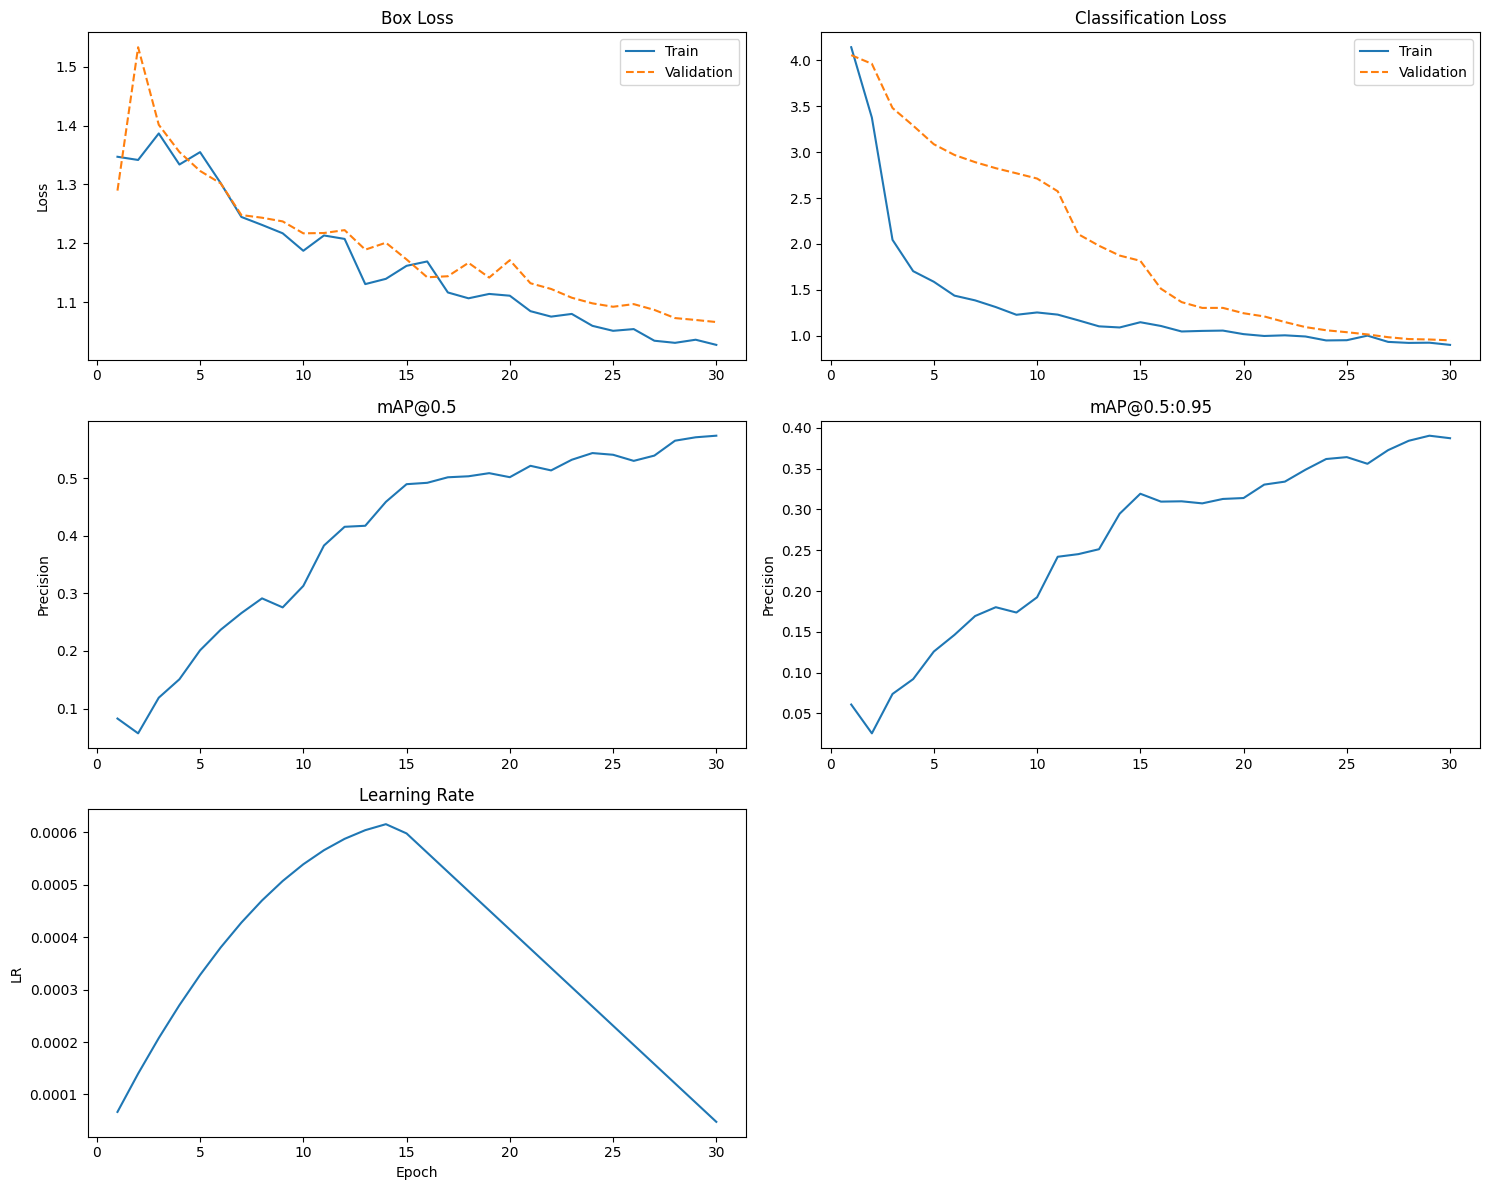

In [28]:
import pandas as pd
import matplotlib.pyplot as plt

# 1. Load and clean your results
results_path = "/content/runs/detect/train6/results.csv"
results = pd.read_csv(results_path)

# Clean column names (remove extra spaces)
results.columns = results.columns.str.strip()

# 2. Create comprehensive plots
plt.figure(figsize=(15, 12))

# Loss metrics
plt.subplot(3, 2, 1)
plt.plot(results['epoch'], results['train/box_loss'], label='Train')
plt.plot(results['epoch'], results['val/box_loss'], label='Validation', linestyle='--')
plt.title('Box Loss')
plt.ylabel('Loss')
plt.legend()

plt.subplot(3, 2, 2)
plt.plot(results['epoch'], results['train/cls_loss'], label='Train')
plt.plot(results['epoch'], results['val/cls_loss'], label='Validation', linestyle='--')
plt.title('Classification Loss')
plt.legend()

# Accuracy metrics
plt.subplot(3, 2, 3)
plt.plot(results['epoch'], results['metrics/mAP50(B)'])
plt.title('mAP@0.5')
plt.ylabel('Precision')

plt.subplot(3, 2, 4)
plt.plot(results['epoch'], results['metrics/mAP50-95(B)'])
plt.title('mAP@0.5:0.95')
plt.ylabel('Precision')

# Learning rate
plt.subplot(3, 2, 5)
plt.plot(results['epoch'], results['lr/pg0'])
plt.title('Learning Rate')
plt.xlabel('Epoch')
plt.ylabel('LR')

plt.tight_layout()
plt.show()

In [29]:
# Find best/worst epochs
best_epoch = results['metrics/mAP50(B)'].idxmax()
print(f"Best Epoch: {best_epoch}")
print(results.iloc[best_epoch][['epoch', 'metrics/mAP50(B)', 'val/box_loss']])

# Plot precision-recall curve
from ultralytics import YOLO
model = YOLO("runs/detect/train6/weights/best.pt")
model.val(plots=True)  # Generates precision-recall curves

Best Epoch: 29
epoch               30.00000
metrics/mAP50(B)     0.57401
val/box_loss         1.06673
Name: 29, dtype: float64
Ultralytics 8.3.170 🚀 Python-3.11.13 torch-2.6.0+cu124 CPU (Intel Xeon 2.20GHz)
Model summary (fused): 72 layers, 3,006,623 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 1312.8±471.3 MB/s, size: 67.7 KB)


val: Scanning /content/your_dataset/Vehicles_Detection.v8i.yolov8/valid/labels.cache... 28 images, 0 backgrounds, 0 corrupt: 100%|██████████| 28/28 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:08<00:00,  4.14s/it]


                   all         28        563      0.736        0.5      0.571       0.39
               class_0          6          6          1      0.316      0.511       0.38
               class_1         23        398      0.698      0.774      0.801      0.551
               class_2         18         92      0.846      0.576      0.615      0.342
               class_3         22         59      0.772       0.46      0.564      0.378
               class_4          8          8      0.365      0.375      0.366        0.3
Speed: 3.2ms preprocess, 257.5ms inference, 0.0ms loss, 22.4ms postprocess per image
Results saved to runs/detect/val


ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0, 1, 2, 3, 4])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7a172a71fcd0>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,
        

**Run Inference**

In [34]:
import os

# Check where your script is running from
print("Current working directory:", os.getcwd())

# Check if files exist at expected location
test_path = '/content/your_dataset/Vehicles_Detection.v8i.yolov8/valid/images/frame_0002_jpg.rf.a929cd43bfa0953ace4ea9ea00fa9ba7.jpg'
print("File exists?", os.path.exists(test_path))

Current working directory: /content
File exists? False


In [35]:
from google.colab import files
import os

# Create directory if needed
os.makedirs('/content/test_images', exist_ok=True)

# Upload interactively (will show file picker)
uploaded = files.upload()

# Move to our test_images folder
for filename in uploaded.keys():
    os.rename(filename, f'/content/test_images/{filename}')

Saving Vehicles_Detection.v8i.yolov8 (3).zip to Vehicles_Detection.v8i.yolov8 (3).zip


In [37]:
import os
import zipfile
from glob import glob
from PIL import Image
from IPython.display import display

# 1. Unzip the dataset (only need to do this once)
zip_path = '/content/sample_data/Vehicles_Detection.v8i.yolov8 (3).zip'
extract_path = '/content/vehicles_data'

if not os.path.exists(extract_path):
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(extract_path)
    print("Extraction complete!")
else:
    print("Files already extracted")

# 2. Locate the validation images
image_paths = sorted(glob(f'{extract_path}/valid/images/*.jpg'))
print(f"Found {len(image_paths)} validation images")

# Quick verification
if image_paths:
    display(Image.open(image_paths[0]))  # Show first image
else:
    print("Error: No images found. Check the extract path!")

Extraction complete!
Found 0 validation images
Error: No images found. Check the extract path!


In [39]:
# Check training images exist
!ls /content/your_dataset/Vehicles_Detection.v8i.yolov8/train/images | head -5

# Check validation images exist
!ls /content/your_dataset/Vehicles_Detection.v8i.yolov8/valid/images | head -5

frame_0002_jpg.rf.a929cd43bfa0953ace4ea9ea00fa9ba7.jpg
frame_0087_jpg.rf.6911e25ecb00139750616b606571e714.jpg
frame_0182_jpg.rf.24ccc1dc2e78b06ec38094471560e981.jpg
frame_0435_jpg.rf.b64a627a937f4b21417074ddc983c184.jpg
frame_0654_jpg.rf.a078b9fb055bd8aabc4ea0269670ec31.jpg
frame_0143_jpg.rf.f11c115e321f53745290e2b2dfcad380.jpg
frame_0911_jpg.rf.f800706c68aaa14bb6a69146facf7e48.jpg
frame_1002_jpg.rf.2b25d8377146e3cf66aea4b2f3836d2d.jpg
frame_1007_jpg.rf.0cbfce7666ca0c0b40922863f0b9484c.jpg
frame_1010_jpg.rf.130eb218ff310e902d6f889e3fc756ee.jpg


In [40]:
import os
from glob import glob

# 1. Define your dataset root (adjust based on actual location)
dataset_root = '/content/your_dataset/Vehicles_Detection.v8i.yolov8'

# 2. Get your specific validation images (from your list)
val_images = [
    'frame_0002_jpg.rf.a929cd43bfa0953ace4ea9ea00fa9ba7.jpg',
    'frame_0087_jpg.rf.6911e25ecb00139750616b606571e714.jpg',
    'frame_0182_jpg.rf.24ccc1dc2e78b06ec38094471560e981.jpg',
    'frame_0435_jpg.rf.b64a627a937f4b21417074ddc983c184.jpg'
]

# 3. Build full paths
image_paths = [f"{dataset_root}/valid/images/{img}" for img in val_images]

# 4. Verify paths exist
missing = [p for p in image_paths if not os.path.exists(p)]
if missing:
    print(f"Missing files: {missing}")
else:
    print("All files found - proceeding with inference")

    # 5. Run inference
    results = model.predict(image_paths,
                          conf=0.3,
                          save=True,
                          save_txt=True)

    # 6. Display results
    for r in results:
        print(f"\nResults for {os.path.basename(r.path)}:")
        display(r.show())  # Colab-friendly display
        print("Detected objects:")
        for box in r.boxes:
            print(f"- {model.names[int(box.cls)]} (confidence: {box.conf:.2f})")

Missing files: ['/content/your_dataset/Vehicles_Detection.v8i.yolov8/valid/images/frame_0002_jpg.rf.a929cd43bfa0953ace4ea9ea00fa9ba7.jpg', '/content/your_dataset/Vehicles_Detection.v8i.yolov8/valid/images/frame_0087_jpg.rf.6911e25ecb00139750616b606571e714.jpg', '/content/your_dataset/Vehicles_Detection.v8i.yolov8/valid/images/frame_0182_jpg.rf.24ccc1dc2e78b06ec38094471560e981.jpg', '/content/your_dataset/Vehicles_Detection.v8i.yolov8/valid/images/frame_0435_jpg.rf.b64a627a937f4b21417074ddc983c184.jpg']


In [42]:
import os
import zipfile

# Path to your zip file
zip_path = '/content/sample_data/Vehicles_Detection.v8i.yolov8 (3).zip'
extract_to = '/content/vehicles_data'

# Create directory if needed
os.makedirs(extract_to, exist_ok=True)

# Unzip the file (only need to do this once)
if not os.path.exists(os.path.join(extract_to, 'valid')):
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(extract_to)
    print("Dataset extracted successfully!")
else:
    print("Dataset already extracted")

# Verify the structure
!ls {extract_to}

Dataset extracted successfully!
Vehicles_Detection.v8i.yolov8


In [44]:
import os
from IPython.display import display, Markdown

# 1. First, let's confirm the exact extracted structure
dataset_root = '/content/vehicles_data'
valid_images_path = os.path.join(dataset_root, 'valid', 'images')

# 2. Check if the directory exists
if not os.path.exists(valid_images_path):
    display(Markdown("**Error**: The validation images directory doesn't exist!"))
    display(Markdown(f"Current structure in {dataset_root}:"))
    !ls -R {dataset_root} | head -20
else:
    # 3. Get ACTUAL filenames (they might have different suffixes)
    actual_files = os.listdir(valid_images_path)
    display(Markdown(f"**Found {len(actual_files)} images in validation set**"))
    display(Markdown("First 5 files:"))
    display(actual_files[:5])

    # 4. Try to match your requested files
    display(Markdown("\n**Matching your requested files:**"))
    found_count = 0
    for requested in val_images:
        # Find matching file (might have different .rf. suffix)
        matches = [f for f in actual_files if requested.split('.rf.')[0] in f]
        if matches:
            print(f"✓ Found match for {requested}: {matches[0]}")
            found_count += 1
        else:
            print(f"✗ No match for {requested}")

    # 5. Solution: Use the ACTUAL filenames we found
    if found_count > 0:
        display(Markdown("\n**Solution:** Use these corrected paths:"))
        corrected_paths = [os.path.join(valid_images_path, f) for f in actual_files if any(req.split('.rf.')[0] in f for req in val_images)]
        for path in corrected_paths:
            print(path)

        # Now you can use corrected_paths with model.predict()
    else:
        display(Markdown("\n**No matches found**. Possible issues:"))
        display(Markdown("- The ZIP file might contain different images"))
        display(Markdown("- The filenames might have changed"))

**Error**: The validation images directory doesn't exist!

Current structure in /content/vehicles_data:

/content/vehicles_data:
Vehicles_Detection.v8i.yolov8

/content/vehicles_data/Vehicles_Detection.v8i.yolov8:
data.yaml
test
train
valid

/content/vehicles_data/Vehicles_Detection.v8i.yolov8/test:
images
labels

/content/vehicles_data/Vehicles_Detection.v8i.yolov8/test/images:
frame_0990_jpg.rf.a3223422e734a57442ee34a58d24d4b4.jpg
frame_1004_jpg.rf.a6f441255e54620ea11fb3cf34fc0a97.jpg
frame_1018_jpg.rf.185b0b25bb53e1d0eb860dda162bb2ae.jpg
frame_1806_jpg.rf.4583992e61114207bd9379b7e0652549.jpg
frame_3837_jpg.rf.7cdff66e6350318c835a7cf1b35525f0.jpg
frame_4363_jpg.rf.1b2237d870de9cc7618a46bf229d23ed.jpg


In [45]:
import os
from IPython.display import display, Markdown

# 1. Update the base path to include the nested folder
dataset_root = '/content/vehicles_data/Vehicles_Detection.v8i.yolov8'
valid_images_path = os.path.join(dataset_root, 'valid', 'images')

# 2. Verify the corrected path exists
if not os.path.exists(valid_images_path):
    display(Markdown("**Error**: Still can't find validation images!"))
    !ls -R {dataset_root} | head -20
else:
    display(Markdown(f"**Success! Found validation images at:** `{valid_images_path}`"))

    # 3. List available images
    actual_files = sorted(os.listdir(valid_images_path))
    display(Markdown(f"Found {len(actual_files)} validation images. First 5:"))
    display(actual_files[:5])

    # 4. Find your specific frames (using partial matching)
    target_frames = [
        'frame_0002_jpg',
        'frame_0087_jpg',
        'frame_0182_jpg',
        'frame_0435_jpg'
    ]

    matched_paths = []
    for frame in target_frames:
        matches = [f for f in actual_files if frame in f]
        if matches:
            matched_paths.append(os.path.join(valid_images_path, matches[0]))

    # 5. Results
    if matched_paths:
        display(Markdown("\n**Matched files:**"))
        for path in matched_paths:
            print(path)

        # Now you can use these paths with model.predict()
    else:
        display(Markdown("\n**No matches found**. Try:"))
        display(Markdown("- Checking different frame numbers"))
        display(Markdown("- Using the test set images instead"))
        display(Markdown("Available test images:"))
        !ls {dataset_root}/test/images | head -5

**Success! Found validation images at:** `/content/vehicles_data/Vehicles_Detection.v8i.yolov8/valid/images`

Found 28 validation images. First 5:

['frame_0143_jpg.rf.f11c115e321f53745290e2b2dfcad380.jpg',
 'frame_0911_jpg.rf.f800706c68aaa14bb6a69146facf7e48.jpg',
 'frame_1002_jpg.rf.2b25d8377146e3cf66aea4b2f3836d2d.jpg',
 'frame_1007_jpg.rf.0cbfce7666ca0c0b40922863f0b9484c.jpg',
 'frame_1010_jpg.rf.130eb218ff310e902d6f889e3fc756ee.jpg']


**No matches found**. Try:

- Checking different frame numbers

- Using the test set images instead

Available test images:

frame_0990_jpg.rf.a3223422e734a57442ee34a58d24d4b4.jpg
frame_1004_jpg.rf.a6f441255e54620ea11fb3cf34fc0a97.jpg
frame_1018_jpg.rf.185b0b25bb53e1d0eb860dda162bb2ae.jpg
frame_1806_jpg.rf.4583992e61114207bd9379b7e0652549.jpg
frame_3837_jpg.rf.7cdff66e6350318c835a7cf1b35525f0.jpg



0: 640x640 2 class_1s, 1 class_4, 198.5ms
1: 640x640 24 class_1s, 2 class_2s, 198.5ms
2: 640x640 15 class_1s, 9 class_2s, 3 class_3s, 198.5ms
3: 640x640 15 class_1s, 7 class_2s, 1 class_3, 198.5ms
Speed: 6.3ms preprocess, 198.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)
Results saved to runs/detect/predict
4 labels saved to runs/detect/predict/labels

Image 1: frame_0143_jpg.rf.f11c115e321f53745290e2b2dfcad380.jpg


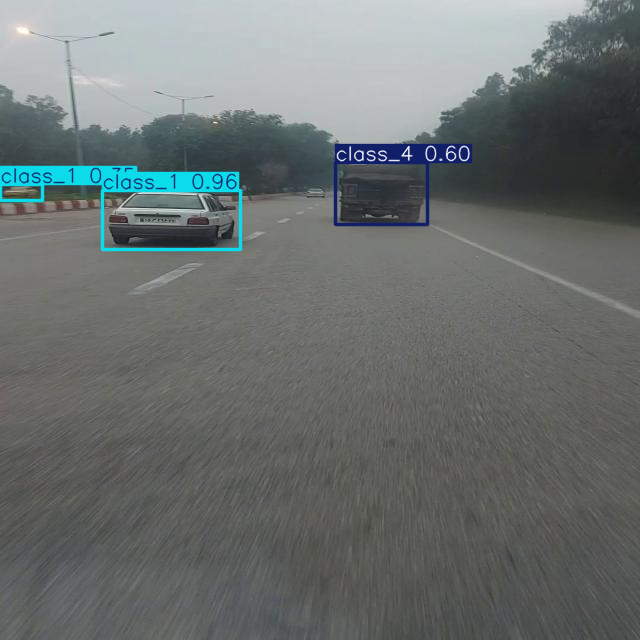

None

Detected objects:
  class_1 (0.96)
  class_4 (0.60)
  class_1 (0.35)

Image 2: frame_0911_jpg.rf.f800706c68aaa14bb6a69146facf7e48.jpg


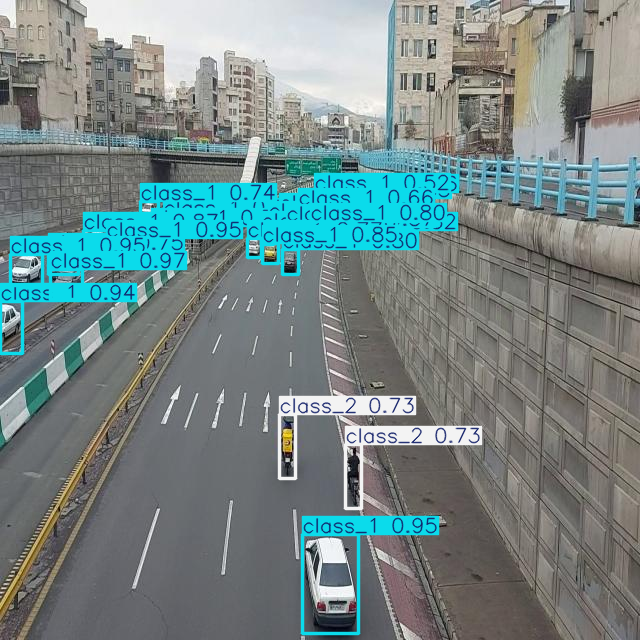

None

Detected objects:
  class_1 (0.97)
  class_1 (0.95)
  class_1 (0.95)
  class_1 (0.95)
  class_1 (0.94)
  class_1 (0.87)
  class_1 (0.85)
  class_1 (0.80)
  class_1 (0.80)
  class_1 (0.77)
  class_1 (0.75)
  class_1 (0.74)
  class_2 (0.73)
  class_2 (0.73)
  class_1 (0.73)
  class_1 (0.70)
  class_1 (0.66)
  class_1 (0.60)
  class_1 (0.59)
  class_1 (0.58)
  class_1 (0.57)
  class_1 (0.52)
  class_1 (0.52)
  class_1 (0.52)
  class_1 (0.36)
  class_1 (0.35)

Image 3: frame_1002_jpg.rf.2b25d8377146e3cf66aea4b2f3836d2d.jpg


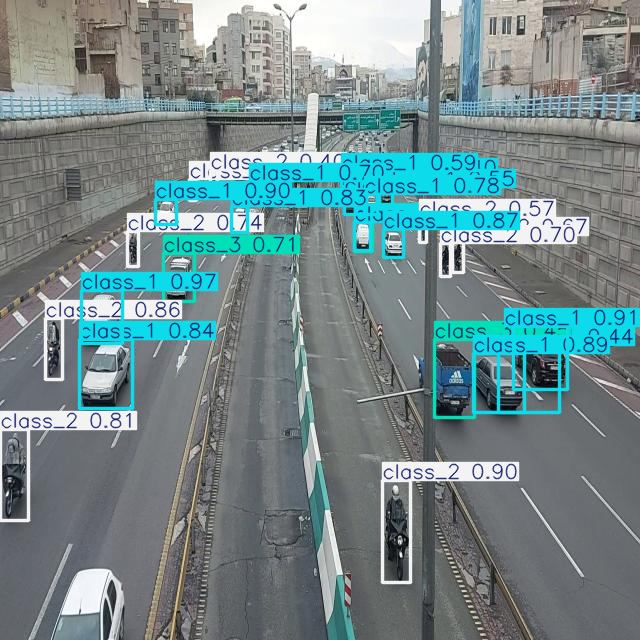

None

Detected objects:
  class_1 (0.97)
  class_1 (0.91)
  class_2 (0.90)
  class_1 (0.90)
  class_1 (0.89)
  class_1 (0.87)
  class_2 (0.86)
  class_1 (0.84)
  class_1 (0.83)
  class_2 (0.81)
  class_1 (0.78)
  class_2 (0.74)
  class_3 (0.71)
  class_2 (0.70)
  class_1 (0.70)
  class_2 (0.67)
  class_1 (0.64)
  class_1 (0.59)
  class_2 (0.57)
  class_1 (0.55)
  class_1 (0.45)
  class_3 (0.45)
  class_1 (0.44)
  class_1 (0.40)
  class_2 (0.40)
  class_2 (0.39)
  class_3 (0.34)

Image 4: frame_1007_jpg.rf.0cbfce7666ca0c0b40922863f0b9484c.jpg


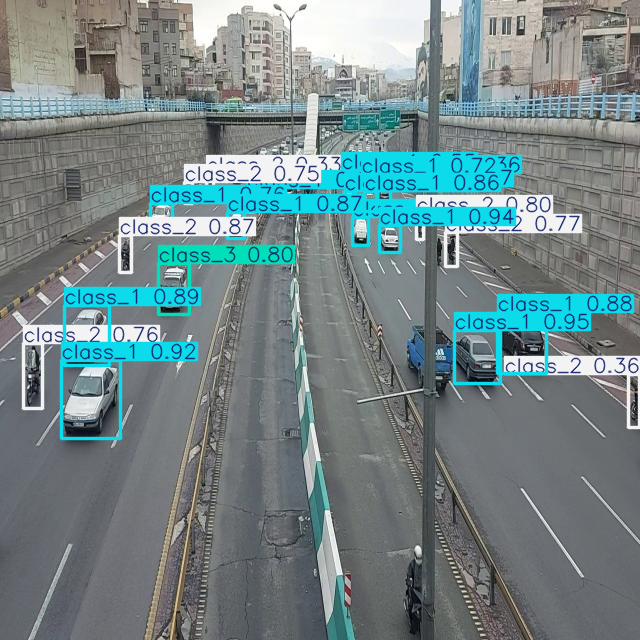

None

Detected objects:
  class_1 (0.95)
  class_1 (0.94)
  class_1 (0.92)
  class_1 (0.89)
  class_1 (0.88)
  class_2 (0.87)
  class_1 (0.87)
  class_1 (0.86)
  class_1 (0.86)
  class_2 (0.80)
  class_3 (0.80)
  class_2 (0.77)
  class_1 (0.76)
  class_2 (0.76)
  class_2 (0.75)
  class_1 (0.72)
  class_1 (0.67)
  class_1 (0.67)
  class_1 (0.55)
  class_2 (0.36)
  class_1 (0.36)
  class_1 (0.34)
  class_2 (0.33)


In [47]:
# Get first 4 validation images
val_images = sorted([f for f in os.listdir(valid_images_path) if f.endswith('.jpg')])[:4]
image_paths = [os.path.join(valid_images_path, img) for img in val_images]

# Run prediction
results = model.predict(image_paths, conf=0.3)

# Display results (with fixed tensor handling)
for i, r in enumerate(results):
    print(f"\nImage {i+1}: {os.path.basename(r.path)}")
    display(r.show())

    if len(r.boxes) > 0:
        print("Detected objects:")
        for box in r.boxes:
            class_id = int(box.cls.item())
            conf = box.conf.item()
            print(f"  {model.names[class_id]} ({conf:.2f})")
    else:
        print("No detections")

**Saving the Model**

In [48]:
from ultralytics import YOLO

# Save in PyTorch format (.pt)
model.save("yolov8_custom.pt")  # Saves to current working directory

# Optional: Export to ONNX for better compatibility
model.export(format="onnx")  # Creates 'yolov8_custom.onnx'

Ultralytics 8.3.170 🚀 Python-3.11.13 torch-2.6.0+cu124 CPU (Intel Xeon 2.20GHz)
💡 ProTip: Export to OpenVINO format for best performance on Intel hardware. Learn more at https://docs.ultralytics.com/integrations/openvino/

PyTorch: starting from 'runs/detect/train6/weights/best.pt' with input shape (1, 3, 640, 640) BCHW and output shape(s) (1, 9, 8400) (6.0 MB)
requirements: Ultralytics requirements ['onnx>=1.12.0,<1.18.0', 'onnxslim>=0.1.59', 'onnxruntime'] not found, attempting AutoUpdate...

requirements: AutoUpdate success ✅ 4.3s
WARNING ⚠️ requirements: Restart runtime or rerun command for updates to take effect


ONNX: starting export with onnx 1.17.0 opset 19...
ONNX: slimming with onnxslim 0.1.61...
ONNX: export success ✅ 7.0s, saved as 'runs/detect/train6/weights/best.onnx' (11.6 MB)

Export complete (7.7s)
Results saved to /content/runs/detect/train6/weights
Predict:         yolo predict task=detect model=runs/detect/train6/weights/best.onnx imgsz=640  
Validate:        yolo 

'runs/detect/train6/weights/best.onnx'

In [49]:
from google.colab import files

# Download both formats
files.download("yolov8_custom.pt")
files.download("yolov8_custom.onnx")  # Optional

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

FileNotFoundError: Cannot find file: yolov8_custom.onnx

In [50]:
from ultralytics import YOLO
from google.colab import files
import os

# 1. Verify model exists
model_path = "yolov8_custom.pt"
if not os.path.exists(model_path):
    raise FileNotFoundError("Model not found - train or load your model first")

# 2. Save PyTorch format (always works)
model.save(model_path)

# 3. Attempt ONNX export (with error handling)
try:
    onnx_path = model.export(format="onnx")  # Returns path of exported model
    print(f"ONNX model saved to: {onnx_path}")
except Exception as e:
    print(f"ONNX export failed: {e}")
    onnx_path = None

# 4. Download what's available
print("\nDownloading files...")
files.download(model_path)  # This will always work

if onnx_path and os.path.exists(onnx_path):
    files.download(onnx_path)
else:
    print("Skipping ONNX download - file not available")

Ultralytics 8.3.170 🚀 Python-3.11.13 torch-2.6.0+cu124 CPU (Intel Xeon 2.20GHz)

PyTorch: starting from 'runs/detect/train6/weights/best.pt' with input shape (1, 3, 640, 640) BCHW and output shape(s) (1, 9, 8400) (6.0 MB)

ONNX: starting export with onnx 1.17.0 opset 19...
ONNX: slimming with onnxslim 0.1.61...
ONNX: export success ✅ 1.4s, saved as 'runs/detect/train6/weights/best.onnx' (11.6 MB)

Export complete (2.1s)
Results saved to /content/runs/detect/train6/weights
Predict:         yolo predict task=detect model=runs/detect/train6/weights/best.onnx imgsz=640  
Validate:        yolo val task=detect model=runs/detect/train6/weights/best.onnx imgsz=640 data=dataset.yaml  
Visualize:       https://netron.app
ONNX model saved to: runs/detect/train6/weights/best.onnx



<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [51]:
import torch
torch.save(model.model.state_dict(), "yolov8_custom_weights.pt")
files.download("yolov8_custom_weights.pt")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [52]:
# 1. Generate requirements.txt with exact versions
!pip freeze > requirements.txt

# 2. Verify the file was created
!head -n 10 requirements.txt  # Show first 10 lines

# 3. Download the file
from google.colab import files
files.download('requirements.txt')

absl-py==1.4.0
accelerate==1.9.0
aiofiles==24.1.0
aiohappyeyeballs==2.6.1
aiohttp==3.12.14
aiosignal==1.4.0
alabaster==1.0.0
albucore==0.0.24
albumentations==2.0.8
ale-py==0.11.2


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>